<a href="https://colab.research.google.com/github/elizabeth-pa/clock-constraints/blob/main/Constraint%20Plot%20Generator/Dark_Matter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emcee
!pip install corner

In [ ]:
import numpy as np
import emcee
import corner

from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.integrate import simps

## MCMC Sampler

In [ ]:
def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):

    mnwalkers, mndim = x0.shape

    sampler = emcee.EnsembleSampler(mnwalkers,
                                    mndim,
                                    log_post)
    sampler.run_mcmc(x0, nburn, progress=True,tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    print('Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=True,tune=True)

    return sampler.get_log_prob(), sampler.get_chain()

def big_sampler(x,y,sigma_y,theoretical_waveform, theta0, log_prior=lambda _:0.0, nburn=300, steps=3000):
    def log_posterior(theta):
        res=np.abs(y-theoretical_waveform(x,theta))/sigma_y
        return -2*np.sum(res**2)/2  + log_prior(theta) # -0.5*np.sum(2*np.pi*sigma_y)

    ndim=len(theta0)
    nwalkers=8*ndim
    p0=np.zeros((nwalkers,ndim))
    for i in range(nwalkers):
        p0[i]=theta0*np.random.normal(loc=1.0, scale=0.001, size=ndim)

    return emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)

def my_priors(pars):
    if pars[1]<0 or pars[2]<0 or pars[2]>2*np.pi:
        return -np.inf
    return 0.

## Modeling the Dark Matter Signal in the Frequency domain

In [ ]:
def hF(f,pars=np.array([7e-22,2*np.pi/(86400*365),1.])):
    A=pars[0]
    omega=pars[1]
    phi=pars[2]

    return (1/dt)*(A/omega)*np.exp(-2j*np.pi*f*T)*(
        omega * np.cos(omega * T + phi) - np.exp(2j * np.pi * f * T)
        * (omega * np.cos(phi) + 2j * np.pi *
        f * np.sin(phi)) + 2j * np.pi * f * np.sin(omega * T + phi)
        )/(4 * np.pi * np.pi * f *f - omega * omega)

## Generate Data using Two Atomic Clocks

1.   Determine the characteristics of your dataset e.g. number of years, sampling rate etc.
2.   Generate white and pink noise.
3. Define the power spectral density coefficients of your clock (white and pink noise).
4. Combine PSD of the noise from the two clocks and factor in the sensitivity coefficients according to the formula:
$$
\frac{\Delta R}{R} = \left( K_{X,1} - K_{X,2} \right)\frac{\Delta X}{X}
$$

5. Generate a signal to inject into the noise.
6. Add the signal to the noise to produce the dataset to be passed to the MCMC framework.

In [ ]:
''' Dataset Characteristics '''
########## input ###########
Ts=86400*365
nyr=3.1
T=Ts*nyr
dt=1
N=int(T/dt)

''' Frequency discretization '''

freqs = fftfreq(N, dt)[0:N//2]
fredd=freqs[freqs<5e-6]
fred=fredd[1:]


''' Signal generation '''

Atrue=2e-18
omtrue=2*np.pi/Ts
phitrue=1.
mypars=np.array([Atrue,omtrue,phitrue])

signal=hF(fred,pars=mypars)

''' Noise generation '''

# Clock 1  ########## input ###########
h0a=3e-33
hm1a=7.2e-37
K1=0.
# Clock 2 ########## input ###########
h0b=8e-28
hm1b=2.8e-32
K2=1.

# Combination
h0=h0a+h0b
hm1=hm1a+hm1b
Ktot=abs(K2-K1)

def noise_PSD(f):
    return (h0 + hm1/f)/Ktot

noise=np.sqrt(noise_PSD(fred)*N)*np.exp(-2j*np.pi*np.random.uniform(size=len(fred)))

''' Error samples '''

signoisef=np.abs(noise)

''' Data generation '''

data=signal+noise

## Apply MCMC to Generated Data


In [ ]:
pdf_and_chain_f=big_sampler(fred,data,signoisef,hF,mypars*1.,steps=3000,log_prior=my_priors)

chains_f=pdf_and_chain_f[1]
samples=chains_f.reshape(-1,chains_f.shape[-1])
samples_rescaled=samples-np.mean(samples,axis=0)+mypars # for plotting

100%|██████████| 300/300 [00:01<00:00, 225.60it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 3000/3000 [00:14<00:00, 212.15it/s]


In [ ]:
" calculate covariance and s.d. "
covreduced = np.cov(samples.T)
st_dev =  np.array([np.sqrt(covreduced[0,0]), np.sqrt(covreduced[1,1])])
print(st_dev)

[2.68716479e-23 4.84061830e-13]


## Fisher Information Matrix Computation

<ipython-input-8-660acab543a6>:63: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(2*(np.abs(haop(f))**2)/(noise_PSD(f)*PSD_rescale),f)
<ipython-input-8-660acab543a6>:67: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(2*(np.real(h1(f)*np.conjugate(h2(f))))/(noise_PSD(f)*PSD_rescale),f)


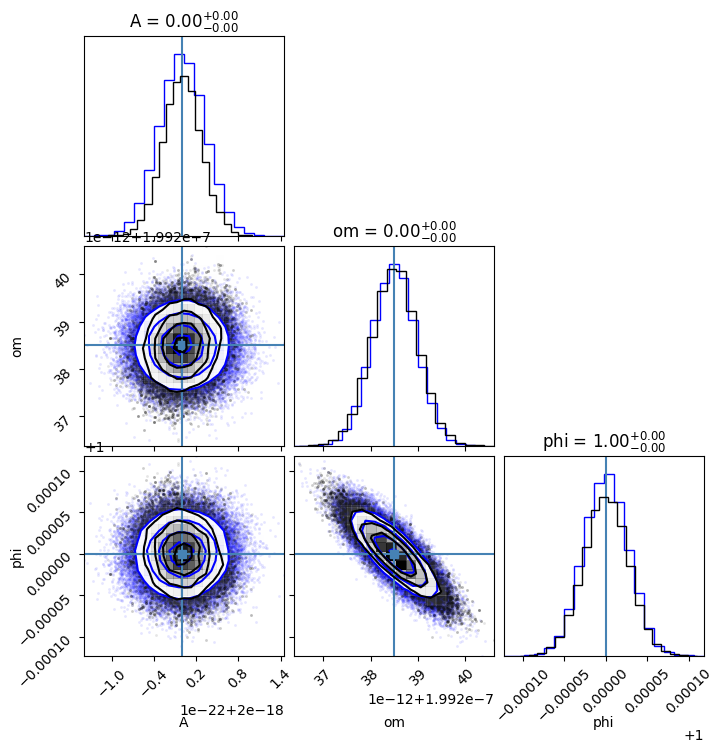

In [ ]:
# Fisher

A_rescale=1e15
PSD_rescale=1e30
Ainj=Atrue*A_rescale

def hA(f):
    omega=omtrue
    phi=phitrue

    return (1/dt)*(1/omega)*np.exp(-2j*np.pi*f*T)*(
        omega*np.cos(omega*T+phi)-np.exp(2j*np.pi*f*T)*(omega*np.cos(phi)+2j*np.pi*f*np.sin(phi))+2j*np.pi*f*np.sin(omega*T+phi)
        )/(4*np.pi*np.pi*f*f-omega*omega)

def hom(f):
    A=Ainj
    omega=omtrue
    phi=phitrue

    pi = np.pi
    I = 1j

    # Define the expression parts
    exp1 = -4 * f**2 * pi**2 * omega + omega**3
    exp2 = -4 * f**2 * pi**2 + 3 * omega**2

    # Construct the full expression
    term1 = -exp2 * (-omega * np.cos(phi + T * omega) +
                    np.exp(2 * I * f * pi * T) * (omega * np.cos(phi) + 2 * I * f * pi * np.sin(phi)) -
                    2 * I * f * pi * np.sin(phi + T * omega))

    term2 = exp1 * (np.exp(2 * I * f * pi * T) * np.cos(phi) +
                    (-1 - 2 * I * f * pi * T) * np.cos(phi + T * omega) +
                    T * omega * np.sin(phi + T * omega))

    numerator = term1 + term2
    denominator = (exp1)**2

    expression = np.exp(-2 * I * f * pi * T) * numerator / denominator

    return (1/dt) * A * expression

def hphi(f):
    A=Ainj
    omega=omtrue
    phi=phitrue

    pi = np.pi
    I = 1j

    numerator = np.exp(-2 * I * f * pi * T) *(-2 * I * f * pi * np.cos(phi + T * omega) +
             np.exp(2 * I * f * pi * T) * (2 * I * f * pi * np.cos(phi) - omega * np.sin(phi)) +
             omega * np.sin(phi + T * omega))

    denominator = (-4 * f**2 * pi**2 * omega + omega**3)

    expression = numerator / denominator

    return (1/dt)*A*expression


def diag_F(f,haop):
    return simps(2*(np.abs(haop(f))**2)/(noise_PSD(f)*PSD_rescale),f)
    #return np.sum(2*(np.abs(haop(f))**2)/(noise_PSD(f)*N))

def offdiag_F(f,h1,h2):
    return simps(2*(np.real(h1(f)*np.conjugate(h2(f))))/(noise_PSD(f)*PSD_rescale),f)
    #return np.sum(2*(np.real(h1(f)*np.conjugate(h2(f))))/(noise_PSD(f)*N))

FFop=np.array([[diag_F(fred,hA),offdiag_F(fred,hA,hom),offdiag_F(fred,hA,hphi)],
               [offdiag_F(fred,hA,hom),diag_F(fred,hom),offdiag_F(fred,hphi,hom)],
               [offdiag_F(fred,hA,hphi),offdiag_F(fred,hphi,hom),diag_F(fred,hphi)]])
FFcov=np.linalg.inv(FFop)


Al, oml, phil = np.random.multivariate_normal(np.array([Ainj,omtrue,phitrue]), FFcov, samples.shape[0]).T
sampomphi=np.array([Al,oml,phil]).T
sampomphi[:,0]=sampomphi[:,0]/A_rescale

my_figureomphi = corner.corner(sampomphi, labels=["A","om", "phi"], show_titles=True,truths=mypars,color='b')
corner.corner(samples_rescaled,fig=my_figureomphi)
plt.show()

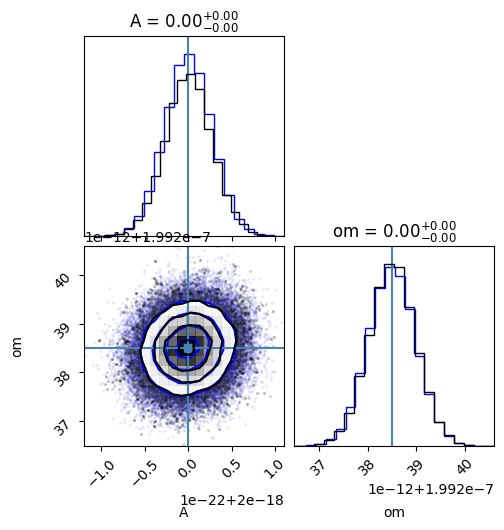

In [ ]:
# Marginalizing over phi
covreduced=np.cov(samples_rescaled.T)[:2,:2]
Ar, omr = np.random.multivariate_normal(np.array([Atrue,omtrue]), covreduced, samples.shape[0]).T
sampAom=np.array([Ar,omr]).T

my_figureomphir = corner.corner(sampAom, labels=["A","om", "phi"], show_titles=True,truths=mypars[:2],color='b')
corner.corner(samples_rescaled[:,:2],fig=my_figureomphir)
plt.show()

## Dark Matter Model

The model is given by the equation:

$d = \frac{\sqrt{2\rho}}{M \cdot m} \cdot \cos(m \cdot t + \phi)$

This can be parameterized as:

$d = A \cdot \cos(\omega \cdot t + \phi)$

### Errors

The errors in the amplitude $A$ and frequency $\omega$ are given by:

$\sigma_A = sA_0 \cdot \sqrt{\frac{\omega}{\omega_0}}$

$\sigma_\omega = s\omega_0 \cdot \sqrt{\frac{\omega}{\omega_0}} \cdot \frac{A_0}{A}$

### Threshold Curve

The threshold curve is defined as:

$A > \sqrt{\sigma_A^2 + \frac{A^2}{\omega^2} \cdot \sigma_\omega^2}$

Substituting the error terms:

$A > \sqrt{sA_0^2 \cdot \frac{\omega}{\omega_0} + \frac{s\omega_0^2 \cdot A_0^2}{\omega^2} \cdot \frac{\omega}{\omega_0}}$

This describes the threshold condition for the amplitude $A$ based on the errors in the model.


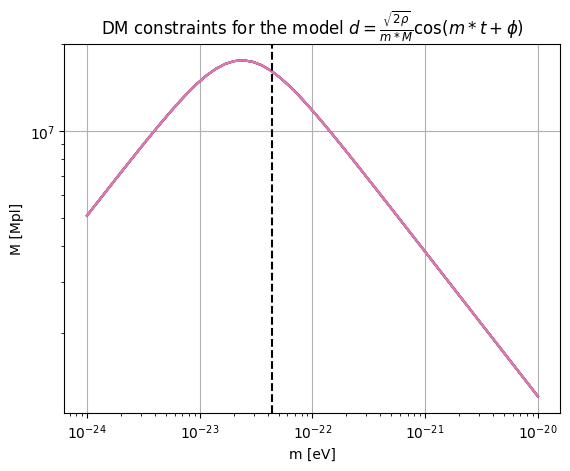

In [ ]:
####### PLOTTER ###########

hbar=4.135667696e-15/(2*np.pi)
Mpl=1.22e28
A0f=2e-18
om0f=1.99e-7

def A_thr(idx,omf):
    return np.sqrt( st_dev[0]**2 * (omf/om0f) + st_dev[1]**2 * (A0f/omf)**2 * (omf/om0f) )

def Mmass(a,rhoDM=2.6e-6): # in units of Mpl
    return np.sqrt(2*rhoDM)/(hbar*a*Mpl)

def Mmass_of_m(m,idx,rhoDM=2.6e-6):
    return Mmass(A_thr(idx,m/hbar),rhoDM=rhoDM)

mplot_range=np.logspace(-24,-20)

for i in range(len(st_dev_list)):
    plt.loglog(mplot_range,Mmass_of_m(mplot_range,i))

plt.axvline(x=2*np.pi*3.15e7**(-1)*hbar/3,c='k', linestyle='--')
plt.title('DM constraints for the model '+r"$d=\frac{\sqrt{2\rho}}{m*M}\cos(m*t+\phi)$")
plt.xlabel(r"m [eV]")
plt.ylabel(r"M [Mpl]")
plt.grid()
plt.show()